## Manuscript figures 

Notebook generates figures 3-10 and tables 4-6 in Krell et al. (2021) Water Resources Research.

In [1]:
## Import packages
## We need to add the module path to our system path so 
## so that our notebook can find our local objects and code:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
     
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
from math import exp
import seaborn as sns
import sys
import glob
from dateutil.relativedelta import *
from numpy.random import exponential, uniform
import scipy.stats as st
from statistics import mean 

# Import objects
from farm import Climate
from farm import Soil
from farm import Crop
from farm import CropModel
from farm.functions import *
from farm.climate import make_climate_parameters, check_exponential, Climate

# Set background color
plot.rc['figure.facecolor'] = 'white'
plot.rc.axesfacecolor = 'white'

/opt/anaconda3/envs/maize-Toff/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


0.9343848966822587
m 0.027663781543337797
b -0.663913202486896


<Figure size 600x400 with 0 Axes>

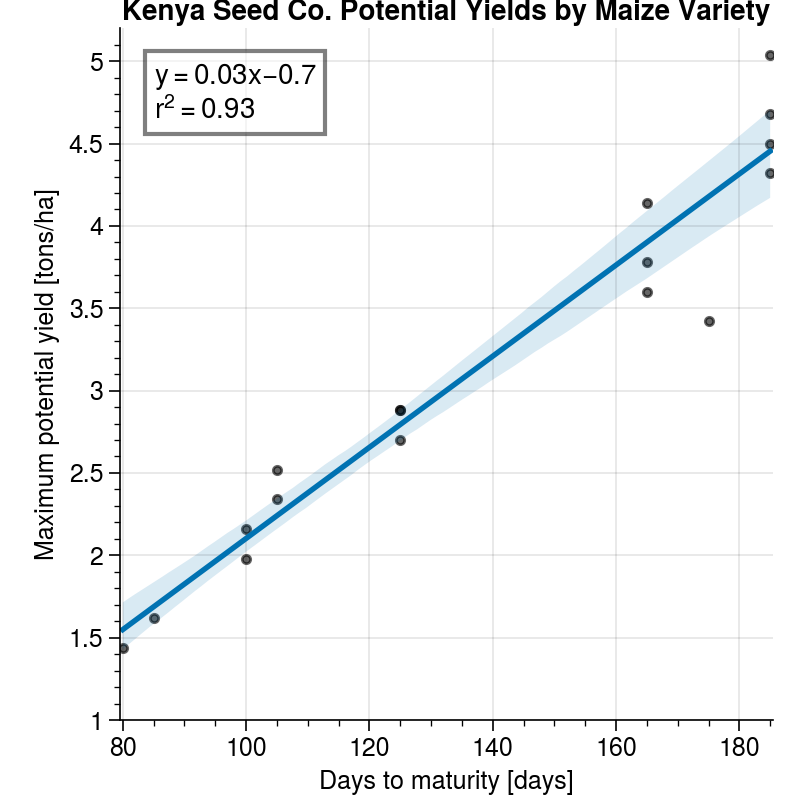

In [2]:
## Figure 3. Kenya Seed Company Yields
def plot_lin_regression(x_var = None, y_var = None, x_str = None, y_str = None, data = None, 
                            ann_x = 101, ann_y = 4500, 
                            x_lab = 'X label here', y_lab = 'Y label here', title = 'Title here', positive = False):
        """ Computes linear regression between independent and dependent variable. 
        Usage: plot_lin_regression(x_var, y_var, x_lab, y_lab, title)
            ann_x = where on x-axis annotation should be placed
            ann_y = where on y-axis annotation should be placed
            Returns: R_squared, m, b
        """
        # Define variables
        X, y = x_var, y_var

        # Linear regression
        denominator = X.dot(X) - X.mean() * X.sum()
        m = ( X.dot(y) - y.mean() * X.sum() ) / denominator
        b = (y.mean() * X.dot(X) - X.mean() * X.dot(y) ) / denominator

        y_pred = m*X + b

        col = 'black'
        
        plt.figure(figsize=(6,4))

        g = sns.lmplot(x_str, y_str, data, ci=95, height=4, scatter_kws={'color':col,'alpha':0.6})

        # Calculate residuals
        res = y - y_pred
        tot = y - y.mean()

        R_squared = 1 - res.dot(res) / tot.dot(tot)
        print(R_squared)
        print('m',m)
        print('b',b)

        if positive == True:
            textstr = '\n'.join((
                r'$ y = %.2f$x' % (m, )+'+$  %0.1f$' % (b, ),
                r'$r^2 = %.2f$' % (R_squared, ))) 
        else:
            textstr = '\n'.join((
            r'$ y = %.2f$x' % (m, )+'$  %.1f$' % (b, ),
            r'$r^2 = %.2f$' % (R_squared, )))

        props = dict(boxstyle='square', facecolor='white', alpha=0.5, lw = 1.5)

        # Place a text box in upper left in axes coords
        plt.text(ann_x, ann_y, textstr, fontsize=10, 
                verticalalignment='top', bbox=props)

        plt.xlabel(x_lab)
        plt.ylabel(y_lab)
        plt.ylim(1,5.2)
        plt.title(title, fontweight="bold")
        plt.subplots_adjust(bottom=0.1, left=0.15, wspace=0.5)

        return R_squared, m, b
    
def fig3_varieties():
    # Verified using Kenya Seed Co. - https://web.archive.org/web/20190819125927/http://kenyaseed.com/gallery/maize/
    verified_hybrid_data = pd.read_csv('../data/Yields/hybrid_yields_verified.csv')
    verified_hybrid_data

    # Convert to metric tons
    verified_hybrid_data['yield_metric_tons'] = verified_hybrid_data.verified_yield_kg_acre/1000
    verified_hybrid_data
    
    p, m, b = plot_lin_regression(verified_hybrid_data.verified_days_to_maturity, verified_hybrid_data.yield_metric_tons, 
                                  'verified_days_to_maturity', 'yield_metric_tons', verified_hybrid_data, 
                                  85, 5, 'Days to maturity [days]', 'Maximum potential yield [tons/ha]', 
                                  'Kenya Seed Co. Potential Yields by Maize Variety')
    
fig3_varieties()

Laikipia station data was inputted.
0.78


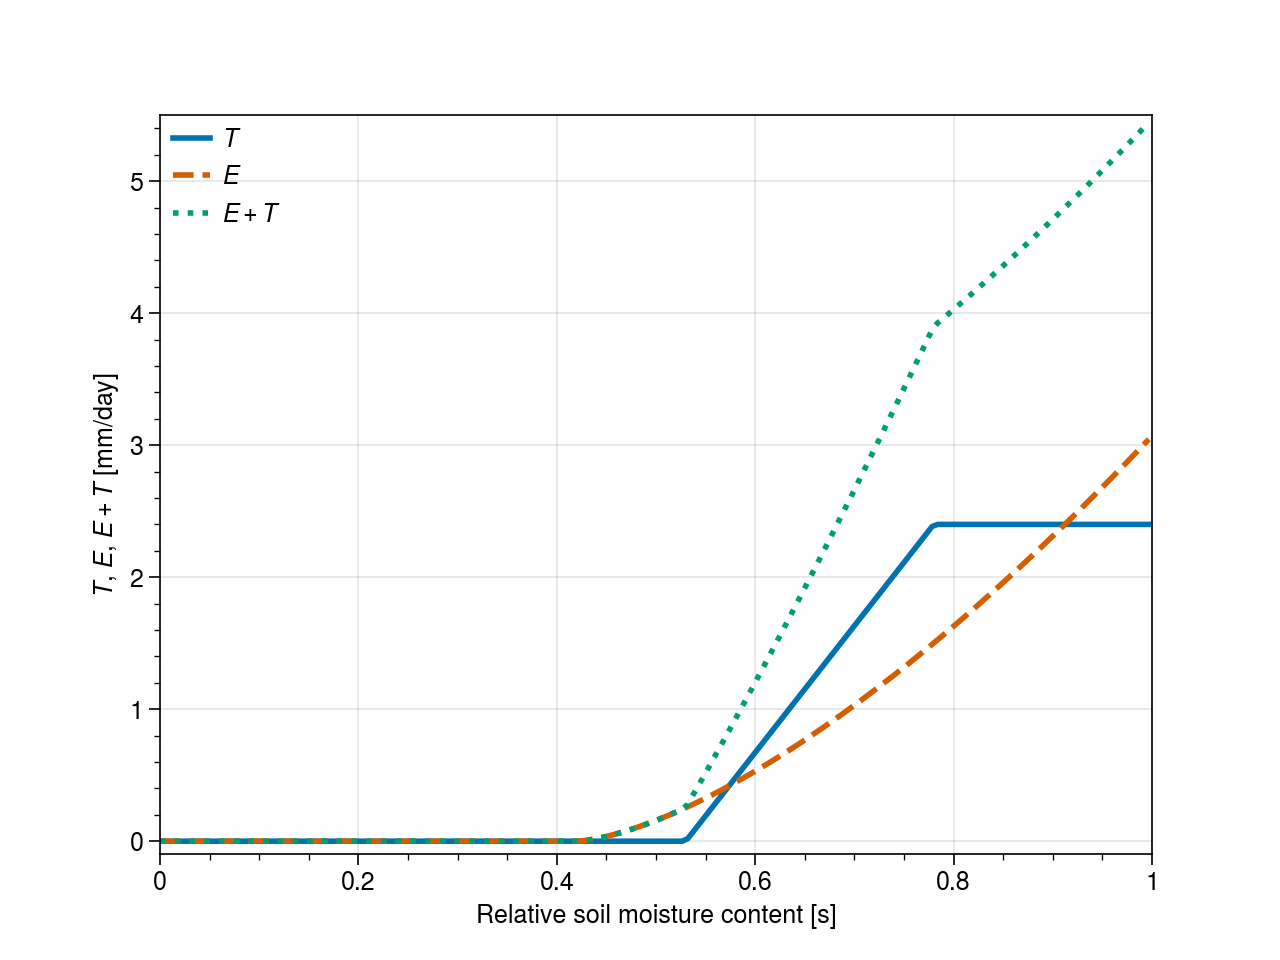

In [3]:
## Figure 4. Time series of T, E, and E+T

# Set OL JOGI climatology for the following figures
station = 'OL JOGI FARM'
interval='dekad'
data_file="../data/CETRAD/CETRAD_rainfall.csv"
texture='clay loam'

a_mid, l_mid, sd = make_climate_parameters(data_file = data_file, station=station, interval=interval) 

# Make a dataframe with these alphas and lambdas
df_mid = pd.DataFrame({'alpha':a_mid, 'lambda':l_mid, 'dekad':np.arange(1,38,1),'doy':['10','20','30','40',
                                                                           '50','60','70','80','90','100',
                                                                            '110','120','130','140','150','160',
                                                                             '170','180','190','200','210','220',
                                                                             '230','240','250','260','270','280','290',
                                                                              '300','310','320','330','340','350','360','365'
                                                                              ]})
climate = Climate(
        data_file=data_file,
        station=station,
        interval=interval,
        alpha_r = a_mid,
        lambda_r = l_mid,
        do_std=False)
    
soil = Soil(texture)
crop = Crop(soil=soil)
soil.set_nZr(crop)  
model = CropModel(crop=crop,soil=soil,climate=climate)

model.run()

# Set saturation variable
s = np.arange(0, 1, 0.0056) #saturation

# Convert to vwc
vwc = s*Soil(texture).n 

def fig4_s_et(s, lai):
    plt.plot(s, [crop.calc_T(x, LAI=lai) for x in s], '-', linewidth=2)
    plt.plot(s, [climate.calc_E(x, LAI=lai, sh=0.42) for x in s],'--', linewidth=2)
    plt.plot(s, [crop.calc_T(x, LAI=lai) + climate.calc_E(x, LAI=lai, sh=0.42) for x in s],':', linewidth=2)

    plt.xlabel('Relative soil moisture content [s]') 
    plt.ylabel('$\mathit{T}$, $\mathit{E}$, $\mathit{E+T}$ [mm/day]') 
    plt.legend(['$\mathit{T}$', '$\mathit{E}$','$\mathit{E+T}$'], frameon=False)
    plt.ylim(-0.1,5.5)
    plt.xlim(0,1)

fig4_s_et(s, lai=1.5)
print(crop.s_star)

In [4]:
# Import the simulations

n_sim = 10000
no_sims = np.arange(0,n_sim)

files = glob.glob('../data/Output/*.csv')

output = []
for f, n in zip(files, no_sims):
    f_ = pd.read_csv(f).drop('Unnamed: 0',axis=1)
    output.append(f_)
    
# Will need average s for Fig. 6
pd_sim = 60 # planting date
lgp = 180 # length of growing period
end = pd_sim + lgp
avg_s = [df[pd_sim:end]['s'].mean() for df in output]

Laikipia station data was inputted.


[Text(0, 0.5, 'Relative soil \n moisture content [s]')]

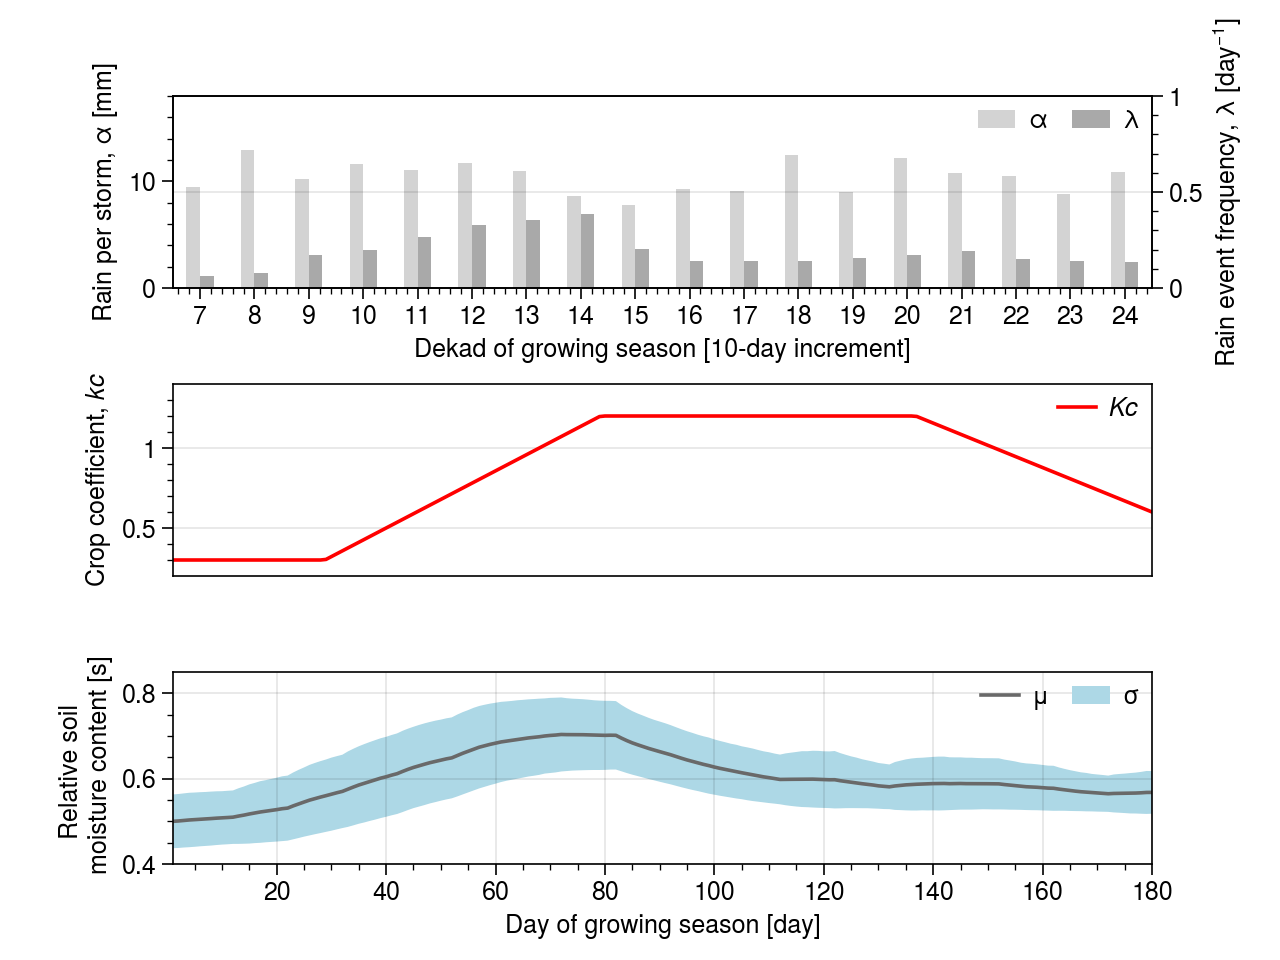

In [5]:
## Fig 5. Three figures to show non-stationarity
s0_climate = Climate(station='OL JOGI FARM', data_file='../data/CETRAD/CETRAD_rainfall.csv', interval='dekad')

# We want the unique values of alpha_r and lambda_r, so grab every 10th element of the list 
a = s0_climate.alpha_r[0::10]
l = s0_climate.lambda_r[0::10]

# Make a dataframe
dekads = pd.DataFrame({'alpha':a, 'lambda':l, 'dekad':np.arange(1,38,1),'day':['10','20','30','40',
                                                                           '50','60','70','80','90','100',
                                                                            '110','120','130','140','150','160',
                                                                               '170','180','190','200','210','220',
                                                                               '230','240','250','260','270','280','290',
                                                                               '300','310','320','330','340','350','360','365'
                                                                              ]})

# Figure set up
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3,ncols=1, sharex=False)
left   =  0.135  # the left side of the subplots of the figure
right  =  0.9    # the right side of the subplots of the figure
bottom =  0.1    # the bottom of the subplots of the figure
top    =  0.9    # the top of the subplots of the figure
wspace =  .3     # the amount of width reserved for blank space between subplots
hspace =  0.5    # the amount of height reserved for white space between subplots

# This function actually adjusts the sub plots using the above paramters
plt.subplots_adjust(
    left    =  left, 
    bottom  =  bottom, 
    right   =  right, 
    top     =  top, 
    wspace  =  wspace, 
    hspace  =  hspace
)

# Subset dataframe
dekads = dekads[6:24].set_index('dekad').drop(['day'], axis=1)

# Plot the dekadal rainfall values
dekads.plot(kind="bar", ax=ax1, ylim=(0,18),rot=360, color=['lightgray','darkgray'])

ax1_ = ax1.twinx()
for r in ax1.patches[len(dekads):]:
    r.set_transform(ax1_.transData)

ax1.set_ylabel(r'Rain per storm, $\alpha$ [mm]')
ax1_.set_ylabel('Rain event frequency, $\lambda$ [day$^{-1}$]')
ax1.legend([r'$\alpha$', r'$\lambda$'], ncol=2, frameon=False)
ax1.set_xlabel('Dekad of growing season [10-day increment]')
ax1_.set_xlabel([''])

ax1.grid(which='major',axis='both')
_kc = output[1]['kc']

ax2.plot(_kc, 'r-') 
ax2.set(ylabel='Crop coefficient, $\mathit{kc}$')
ax2.set_ylim(0.2, 1.4)
ax2.legend(['$\mathit{Kc}$'],frameon=False)
ax2.xaxis.set_visible(False)

# Plot c) Saturation
output_s = pd.concat([d for d in output], axis=1) 
avg_df_180 = output_s['s'].dropna() 
avg_df_180["mean"] = avg_df_180.mean(axis=1)  
avg_df_180["var"] = avg_df_180.std(axis=1) 

avg_df_180.index = avg_df_180.index+1 # make doy cooperate better

# Convert to vwc
ax3.plot(avg_df_180['mean'], 'dimgray')
ax3.set_ylim(0.4, 0.85)

x = np.arange(1, 181, 1)
ax3.fill_between(x, avg_df_180['var']+avg_df_180['mean'], avg_df_180['mean']-avg_df_180['var'],facecolor='lightblue')
ax3.set(xlabel='Day of growing season [day]') 
ax3.legend(['$\mu$','$\sigma$'], ncol=2, frameon=False)
ax3.set(ylabel='Relative soil \n moisture content [s]')

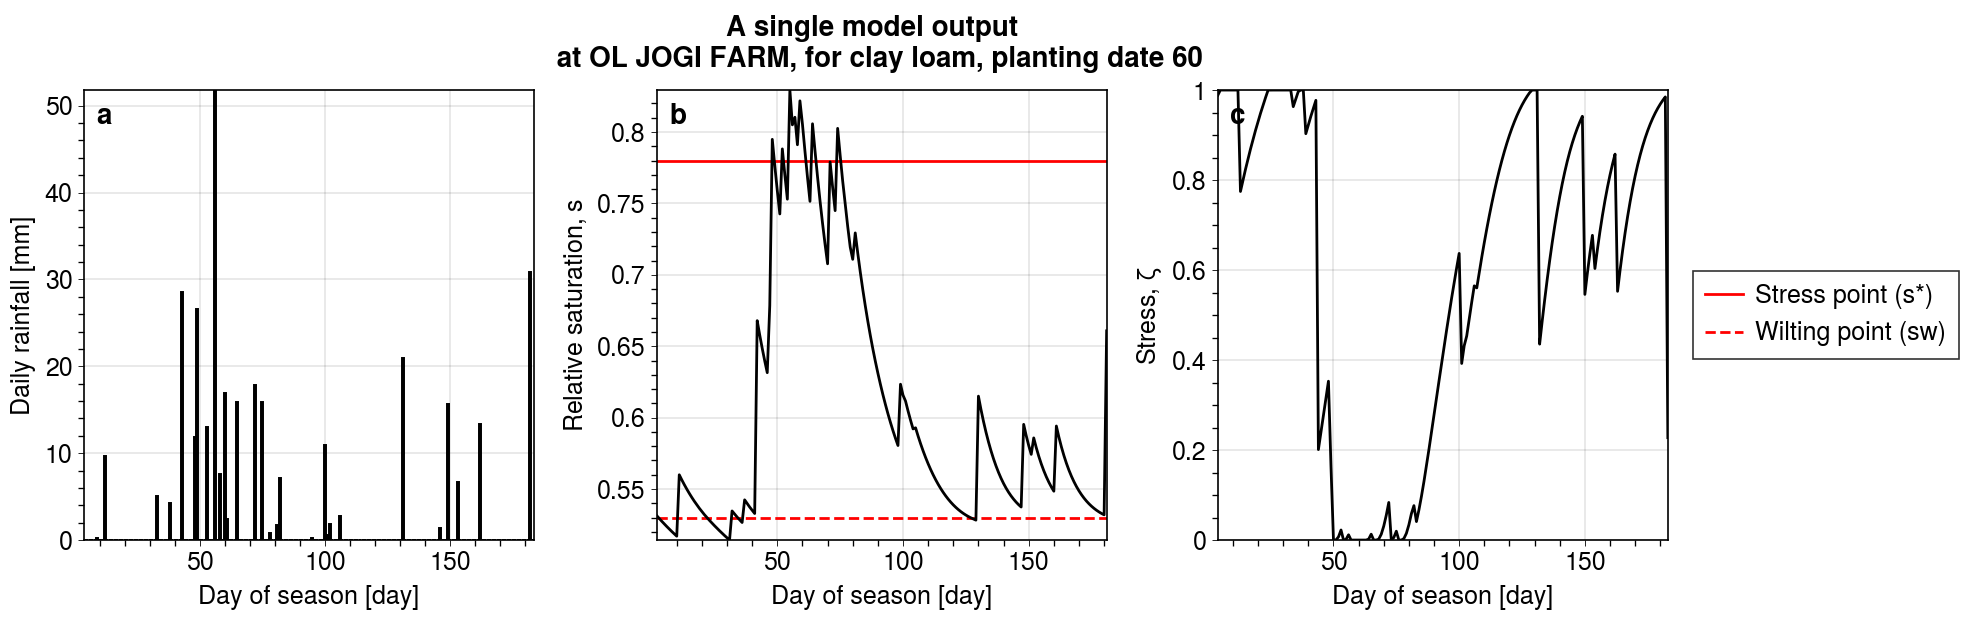

In [10]:
## Fig. 6: Time series of rainfall, s, and stress

def figure6(output, avg_s):
    """ Generates time series of rainfall, saturation, and stress.

    Usage: figure6(output, avg_s)
        Takes the output from the time series and the average saturation variables.

    """
    f, axs = plot.subplots(nrows = 1, ncols = 3, share=0)
    axs.format(
        abc=True, abcloc='ul', suptitle='A single model output \n at %s' %station + ', for %s' %texture + ', planting date %s' %pd_sim
    )
    axs.tick_params('both', length=2, width=0.3, which='major', colors='k')

    lowest = 1 # decide which simulation you want to plot
    # Figure 1a: Rainfall from one simulation
    rf = output[lowest]['R']
    stress = output[lowest]['stress']
    
    # Adjust index to account for the fact that python is zero-indexed
    rf.index = rf.index+1 # change index so that we can see day of season
    stress.index = stress.index+1
    
    axs[0,0].bar(rf, color='k', edgecolor='k') 
    axs[0,0].format(ylabel='Daily rainfall [mm]')
    axs[0,0].format(xlabel='Day of season [day]')
    
    # Figure 1c: stress from one simulation
    axs[0,2].plot(stress, color='k', lw=1)
    axs[0,2].format(ylabel='Stress, $\zeta$')
    axs[0,2].format(xlabel='Day of season [day]')
        
    # Figure 1b: Soil moisture from one simulation
    s = output[lowest]['s']
    _sstar = crop.s_star
    _sw = crop.sw
   
    # LEGEND
    hs = []
    cycle = ['-','--']
    var = [_sstar, _sw]
    LABEL = ['Stress point (s*)','Wilting point (sw)']
    
    for item, cycle, LABEL in zip(var, cycle, LABEL):
        h = axs[0,1].axhline(y=item, lw=1, color='r', linestyle=cycle, label=LABEL)
        hs.append(h)
    
    f.legend(hs, loc='right', ncols=1, frame=True)
    
    # Adjust index to account for the fact that python is zero-indexed
    s.index = s.index + 1
    
    axs[0,1].plot(s, color='k', lw=1) # plot vwc for vwc
    axs[0,1].format(ylabel=r'Relative saturation, $s$')
    axs[0,1].format(xlabel='Day of season [day]')

figure6(output, avg_s)

/opt/anaconda3/envs/maize-Toff/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/maize-Toff/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


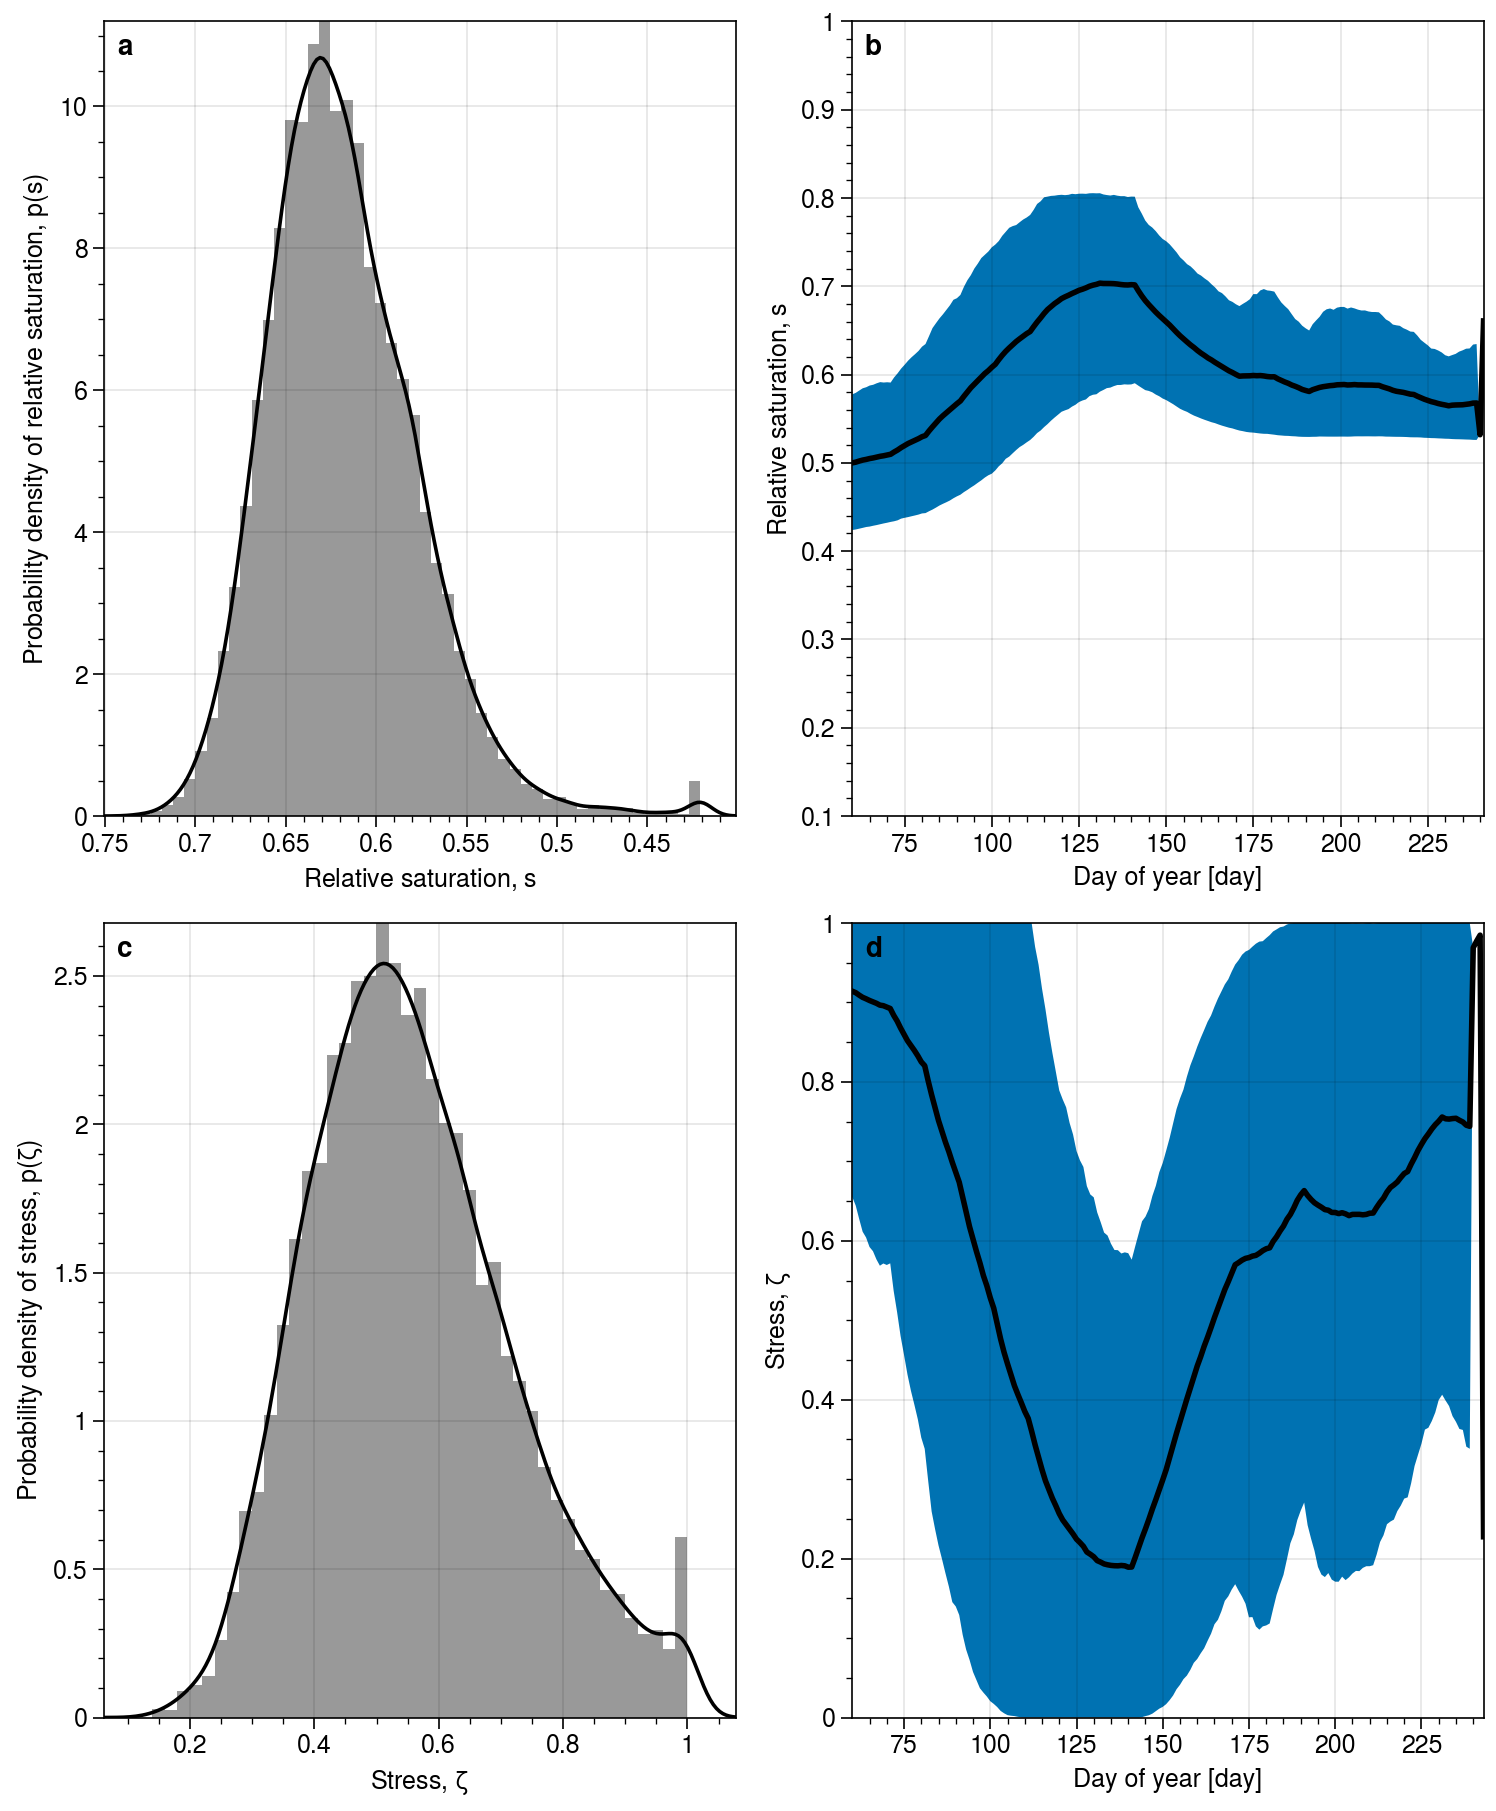

In [13]:
## Figure 7: PDFs and time series

col = 'black'
f, axs = plot.subplots(nrows=2, ncols=2, share=0, journal='agu4')
axs.format(abc=True, abcloc='ul')

# Figure a: Soil moisture distribution 
ax = axs[0,0]
avg_s_ = np.array(avg_s) 
sns.distplot(avg_s_, ax=ax, color=col, **{'kde': True, 'hist': True}) 
ax.format(ylabel='Probability density of relative saturation, $p(s)$')
ax.format(xlabel='Relative saturation, $s$')

# Figure c: Stress distribution
ax = axs[1,0]
avg_stress = [df['stress'].mean() for df in output]
sns.distplot(avg_stress, ax=ax, color=col,**{'kde': True, 'hist': True}) 
ax.format(ylabel='Probability density of stress, $p(\zeta)$')
ax.format(xlabel='Stress, $\zeta$')

# Figure b: Soil moisture time series
avg_daily = pd.concat([df['s'] for df in output], axis=1); avg_daily
avg_daily = avg_daily 
avg_daily_t = avg_daily.T; avg_daily_t
daily_mean = avg_daily.mean(axis=1); daily_mean
x = np.arange(60, len(daily_mean)+60, 1)
axs[0,1].plot(x, daily_mean, color=col, lw=2)

quant = avg_daily_t.quantile([.1, .9])
quant = quant.T
axs[0,1].fill_between(x, quant[0.1], quant[0.9])
axs[0,1].format(ylim=(0.1, 1))
axs[0,1].format(xlabel='Day of year [day]')
axs[0,1].format(ylabel='Relative saturation, $s$')

# Figure d: Stress time series
avg_daily = pd.concat([df['stress'] for df in output], axis=1); avg_daily
avg_daily_t = avg_daily.T; avg_daily_t
daily_mean = avg_daily.mean(axis=1); daily_mean
x = np.arange(60, len(daily_mean)+60, 1)
axs[1,1].plot(x, daily_mean, color=col, lw=2)

quant = avg_daily_t.quantile([.1, .9])
quant = quant.T
axs[1,1].fill_between(x, quant[0.1], quant[0.9])
axs[1,1].format(xlabel='Day of year [day]')
axs[1,1].format(ylabel='Stress, $\zeta$')

2.7899538799778894


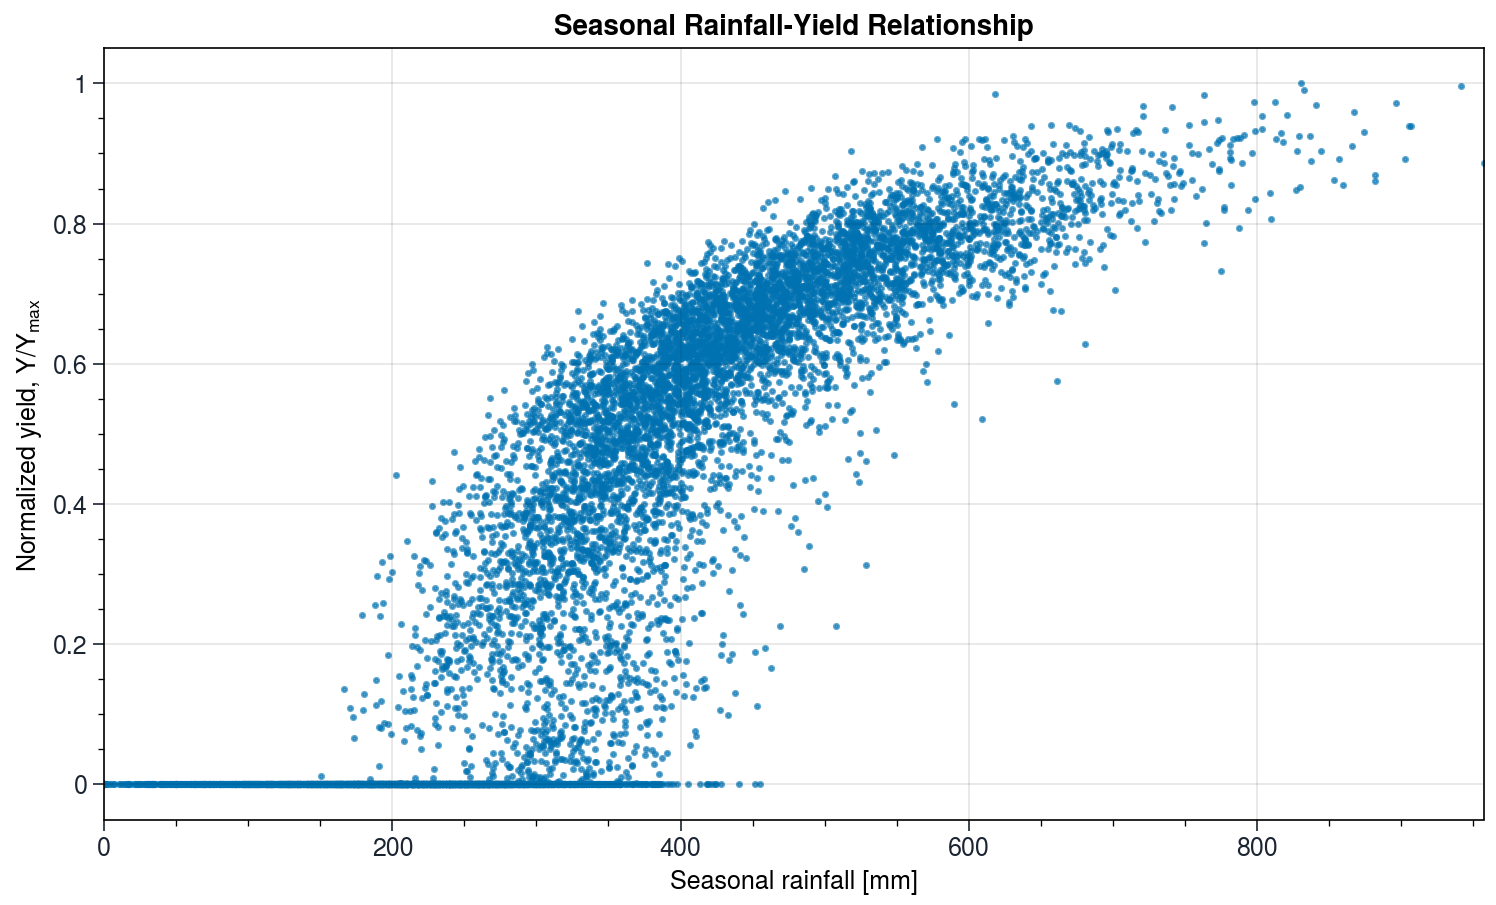

In [14]:
## Figure 8. Dynamic Stress-Rainfall-Yield Relationship

# Line up the data
data = [crop.calc_dstress(s=df.s, stress=df.stress, Y_MAX = evolved_calc_yield(dtm=lgp)) for df in output]
rf = [df['R'].sum() for df in output]
    
# Turn dynamic water stress data into a tuple
df = pd.DataFrame.from_records(data, columns =['AvgStress2','DynamicStress','Yield'])
df['RF'] = rf
print(max(df.Yield))

# Dynamic Stress Yield Rlxn

def fig8(df=None):
    # We'll be using these variables a lot
    x = df.RF
    y = df.Yield

    # Y axis can either be nornalized yield or yield
    df['Yield_norm'] = df.Yield/max(df.Yield)

    f, axs = plot.subplots(journal='agu2')
    axs.format(
        abc=False, abcloc='ul', suptitle='Seasonal Rainfall-Yield Relationship')
    
    cols = 'dark'
    
    plt.scatter(df.RF, df.Yield_norm, alpha=0.6, size=2.5)
    plt.ylim(-.05,1.05)
    plt.ylabel('Normalized yield, $Y/Y_{max}$ ') # Yield normalized by max. yield
    plt.xlabel('Seasonal rainfall [mm]')
    
    axs.tick_params(axis='y', colors=cols)
    axs.tick_params(axis='x', colors=cols)
    
fig8(df=df)

In [15]:
## Fig. 9 Cultivar PDF

result = pd.read_csv('../data/cultivar_result.csv', sep=',').drop('Unnamed: 0', axis=1)

In [16]:
# for average yield need to take non-zero numbers
r0=result
r0[r0 == 0] = np.nan

early = r0.query("Category == 'Early (80 - 110 d)'")
med = r0.query("Category == 'Medium (115 - 145 d)'")
late = r0.query("Category == 'Late (150 - 180 d)'")

# need to use nan mean for Yield because 0s were turned into nans
e_rf, e_y = early.RF.mean(), np.nanmean(early.Yield)
m_rf, m_y = med.RF.mean(), np.nanmean(med.Yield)
l_rf, l_y = late.RF.mean(), np.nanmean(late.Yield)

# Turn nans back to zeros
early = early.fillna(0)
med = med.fillna(0)
late = late.fillna(0)

# Percent of crop failure - calc before turning nans to zero
c_e = len(early.loc[early['Yield'] == 0].count(axis=1))/len(early)*100
c_m = len(med.loc[med['Yield'] == 0].count(axis=1))/len(med)*100
c_l = len(late.loc[late['Yield'] == 0].count(axis=1))/len(late)*100

# code for ticks
import matplotlib.ticker as mticker
f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.1e' % x))
cbar_kws={'format': mticker.FuncFormatter(g)}

In [17]:
# Make the table 
p_desc = ['Early (80 - 110 d)','Medium (115 - 145 d)',  'Late (150 - 180 d)']
rf = [e_rf, m_rf, l_rf]
y = [e_y, m_y, l_y]
c = [c_e, c_m, c_l]

table1 = pd.DataFrame({'Maize Variety':p_desc,
                       'Average Rainfall (mm)': rf,
                       'Average Yield (t/ha)': y,
                       'Probability of Crop Failure (%)':c})

table1 = table1.round({'Average Rainfall (mm)':1,'Average Yield (t/ha)':4,
             'Probability of Crop Failure (%)':2})

print(table1.to_latex(index=False))
table1

\begin{tabular}{lrrr}
\toprule
        Maize Variety &  Average Rainfall (mm) &  Average Yield (t/ha) &  Probability of Crop Failure (\%) \\
\midrule
   Early (80 - 110 d) &                  221.6 &                1.1837 &                            26.77 \\
 Medium (115 - 145 d) &                  270.8 &                1.2305 &                            31.97 \\
   Late (150 - 180 d) &                  328.1 &                1.4547 &                            34.94 \\
\bottomrule
\end{tabular}



,Maize Variety,Average Rainfall (mm),Average Yield (t/ha),Probability of Crop Failure (%)
0,Early (80 - 110 d),221.6,1.1837,26.77
1,Medium (115 - 145 d),270.8,1.2305,31.97
2,Late (150 - 180 d),328.1,1.4547,34.94


/opt/anaconda3/envs/maize-Toff/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/envs/maize-Toff/lib/python3.8/site-packages/seaborn/distributions.py:1678: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/maize-Toff/lib/python3.8/site-packages/seaborn/distributions.py:1181: UserWarning: The following kwargs were not used by contour: 'xlim', 'ylim', 'kind'
  cset = contour_func(
/opt/anaconda3/envs/maize-Toff/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, a

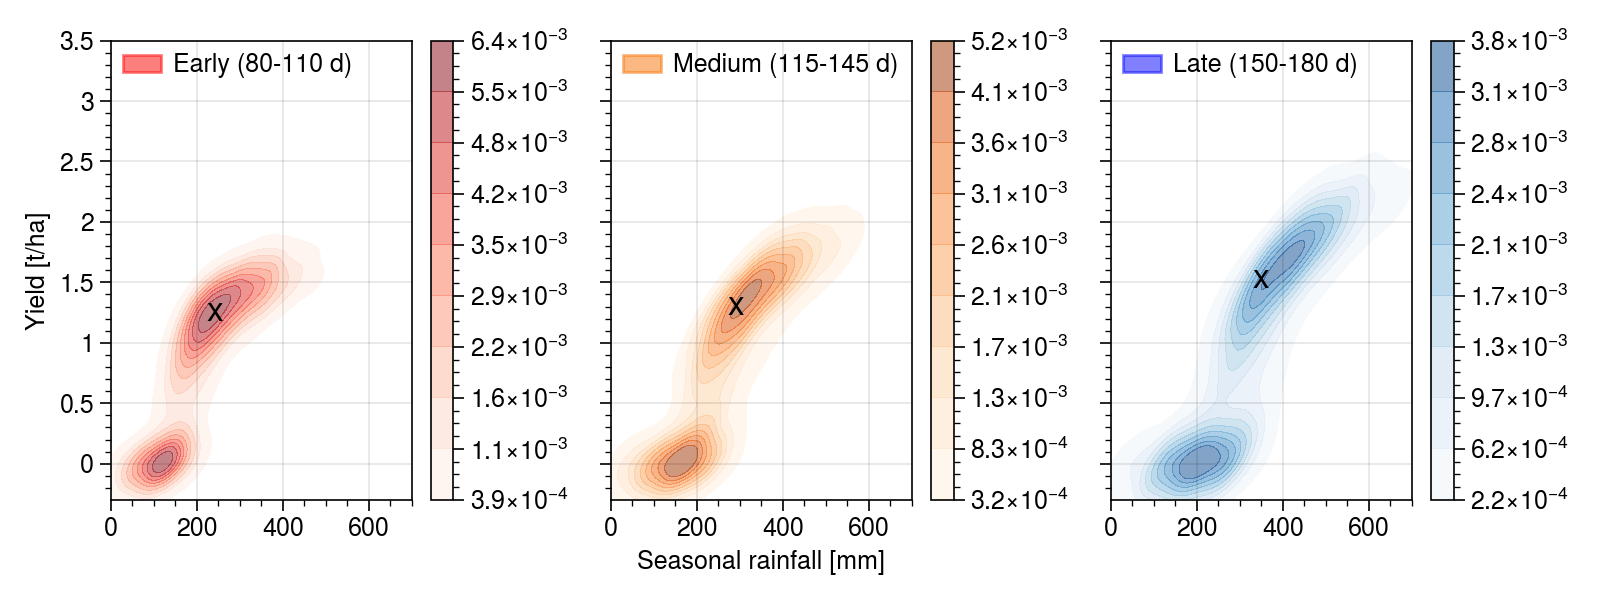

In [18]:
## Fig. 9. Joint PDFs for varieties

def fig_9():
    fig, axes = plt.subplots(ncols=3,nrows=1,figsize=(8,3), sharey=True, sharex=True) 

    # Labels, ticker
    import matplotlib.patches as mpatches
    import matplotlib.ticker as mticker

    red_patch = mpatches.Patch(color='red', label='Early (80-110 d)', alpha=0.5)
    orange_patch = mpatches.Patch(color='orange', label='Medium (115-145 d)', alpha=0.5)
    blue_patch = mpatches.Patch(color='blue', label='Late (150-180 d)', alpha=0.5)

    f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
    g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.1e' % x))

    sns.kdeplot(early.RF, early.Yield, xlim=(0,700),ylim=(-0.3,3.5), alpha=0.5, kind='kde',cmap="reds", shade=True, 
                    shade_lowest=False, cbar=True, ax=axes[0], label='early', cbar_kws={'format': mticker.FuncFormatter(g)})
    ax1 = axes[0]
    ax1.text(e_rf,e_y, "x", size=12, color='k')
    ax1.set(ylabel='Yield [t/ha]')
    ax1.set(xlabel='')
    ax1.legend(handles=[red_patch],loc='upper left', frameon=False)
    ax1.set(ylim=(-0.3,3.5))

    ax2 = axes[1]
    sns.kdeplot(med.RF, med.Yield, xlim=(0,700),ylim=(-0.3,3.5),alpha=0.5,kind='kde',cmap="oranges", 
                      shade=True, shade_lowest=False, cbar=True,ax=ax2, cbar_kws={'format': mticker.FuncFormatter(g)})
    ax2.text(m_rf,m_y,"x",size=12,color='k')
    ax2.set(xlim=(0,700))
    ax2.set(ylabel='')
    ax2.set(xlabel='Seasonal rainfall [mm]')
    ax2.legend(handles=[orange_patch],loc='upper left', frameon=False)


    ax3 = axes[2]
    sns.kdeplot(late.RF, late.Yield,xlim=(0,700),ylim=(-0.3,3.5), alpha=0.5,kind='kde',cmap="blues", shade=True, shade_lowest=False, cbar=True, ax=ax3, cbar_kws={'format': mticker.FuncFormatter(g)}) #greens
    ax3.text(l_rf,l_y, "x", size=12, color='k')
    ax3.set(ylabel='')
    ax3.set(xlabel='')
    ax3.legend(handles=[blue_patch],loc='upper left', frameon=False)

    fig.tight_layout()
    
fig_9()

In [19]:
## Fig. 10: Three eras PDF
result_list = pd.read_csv('../data/eras_result.csv',sep=',').drop(['Unnamed: 0'], axis=1).fillna(0)

In [20]:
# Steps as described in section 2.3.2 in the manuscript:

# 1. Represent the average annual change in either parameter over the period of observation using slope and intercept based on Fig. 2
m_a = 0.066401 # Slope, alpha
m_l = -0.002440 # Slope, lambda

c_a = -122.684507 # Intercept, alpha
c_l = 5.163470 # Intercept, lambda

# 2. Use the entire record to get an estimate of the alpha and lambda for each decad (let’s call this the “seasonally-varying” component of climate, which is determined by the ITCZ, etc…)
station = 'JACOBSON FARM'
interval='dekad'
data_file="../data/CETRAD/CETRAD_rainfall.csv"

a_mid, l_mid, sd = make_climate_parameters(data_file = data_file, station=station, interval=interval) 

# Make a dataframe with these alphas and lambdas
# These will be our alphas and lambdas for the middle of the time series                                                                              ]})
df_mid = pd.DataFrame({'alpha':a_mid, 'lambda':l_mid, 'dekad':np.arange(1,38,1),'doy':['10','20','30','40',
                                                                           '50','60','70','80','90','100',
                                                                            '110','120','130','140','150','160',
                                                                             '170','180','190','200','210','220',
                                                                             '230','240','250','260','270','280','290',
                                                                              '300','310','320','330','340','350','360','365'
                                                                              ]})

# 3. Those average dekad values would correspond to the typical climate in the middle of the record.
# So use those values for alpha, `a_mid`, and lambda, `l_mid`, as the typical climate in the middle of the record.

# 4. To get at the recent (or past) values, we just apply the trend line to each of the individual average dekads to see what the “2020” or “1940" values would be.
# There are 80 years in the record (1934-2014), so we'll add or subtract by 40 years.
# df_mid corresponds to the alpha and lambdas we use for the middle or average values

alphas_2010 = df_mid['alpha']+m_a*40; alphas_2010
alphas_1930 = df_mid['alpha']-m_a*40; alphas_1930

lambdas_2010 = df_mid['lambda']+m_l*40; lambdas_2010 
lambdas_1930 = df_mid['lambda']-m_l*40

In [21]:
# Make table and plot

def make_table(df = None):
    
    # Set up three eras
    r_1930 = df.query('Era == "early"')
    r_avg = df.query('Era == "mid"')
    r_2010 = df.query('Era == "late"')
    
    # Need alphas and lambdas to be set to 180d
    # We want dekad 7 through 25
    a_1930 = alphas_1930[6:26] # zero-index
    a_avg = a_mid[6:24]
    a_2010 = alphas_2010[6:24]
    
    l_1930 = lambdas_1930[6:24] # zero-index
    l_avg = l_mid[6:24]
    l_2010 = lambdas_2010[6:24]
    table = pd.DataFrame({'Rainfall Climatology':['Early: 1930s','Middle: 1970s (Avg)','Late: 2010s'],
                'Maize Variety':[180,180,180],
                'Average Seasonal Alpha (mm)':[mean(a_1930), mean(a_avg), mean(a_2010)],
                'Average Seasonal Lambda (day^-1)':[mean(l_1930), mean(l_avg), mean(l_2010)],
                
                'Average Seasonal Rainfall (mm)':[r_1930.RF.mean(), r_avg.RF.mean(), r_2010.RF.mean()],
                          
                'SD Seasonal  Rainfall':[np.std(r_1930.RF),np.std(r_avg.RF),np.std(r_2010.RF)],
                          
                'CV Seasonal Rainfall':[r_1930.RF.std()/r_1930.RF.mean(), 
                                    r_avg.RF.std()/r_avg.RF.mean(),
                                    r_2010.RF.std()/r_2010.RF.mean()],
                'Average Yield (t/ha)': [np.nanmean(r_1930.Yield), 
                                         np.nanmean(r_avg.Yield), 
                                         np.nanmean(r_2010.Yield)],
                'Probability of Crop Failure (%)':[len(r_1930.loc[r_1930['Yield'] == 0].count(axis=1))/len(r_1930)*100,
                                                   len(r_avg.loc[r_avg['Yield'] == 0].count(axis=1))/len(r_avg)*100,
                                                   len(r_2010.loc[r_2010['Yield'] == 0].count(axis=1))/len(r_2010)*100]})
    return table

table = make_table(result_list); table.round(2)

,Rainfall Climatology,Maize Variety,Average Seasonal Alpha (mm),Average Seasonal Lambda (day^-1),Average Seasonal Rainfall (mm),SD Seasonal Rainfall,CV Seasonal Rainfall,Average Yield (t/ha),Probability of Crop Failure (%)
0,Early: 1930s,180,5.71,0.35,362.31,139.21,0.38,0.72,48.26
1,Middle: 1970s (Avg),180,8.33,0.26,384.59,154.27,0.40,1.05,30.92
2,Late: 2010s,180,10.99,0.16,316.06,135.99,0.43,0.84,32.80


In [22]:
# For average yield need to take non-zero numbers
result_list[result_list == 0] = np.nan

result_early = result_list.query('Era == "early"')
result_mid = result_list.query('Era == "mid"')
result_late = result_list.query('Era == "late"')

# Need to use nan mean for Yield because 0s were turned into nans
e_rf, e_y = result_early.RF.mean(), np.nanmean(result_early.Yield)
m_rf, m_y = result_mid.RF.mean(), np.nanmean(result_mid.Yield)
l_rf, l_y = result_late.RF.mean(), np.nanmean(result_late.Yield)

# Turn nans back to zeros
result_early = result_early.fillna(0)
result_mid = result_mid.fillna(0)
result_late = result_late.fillna(0)

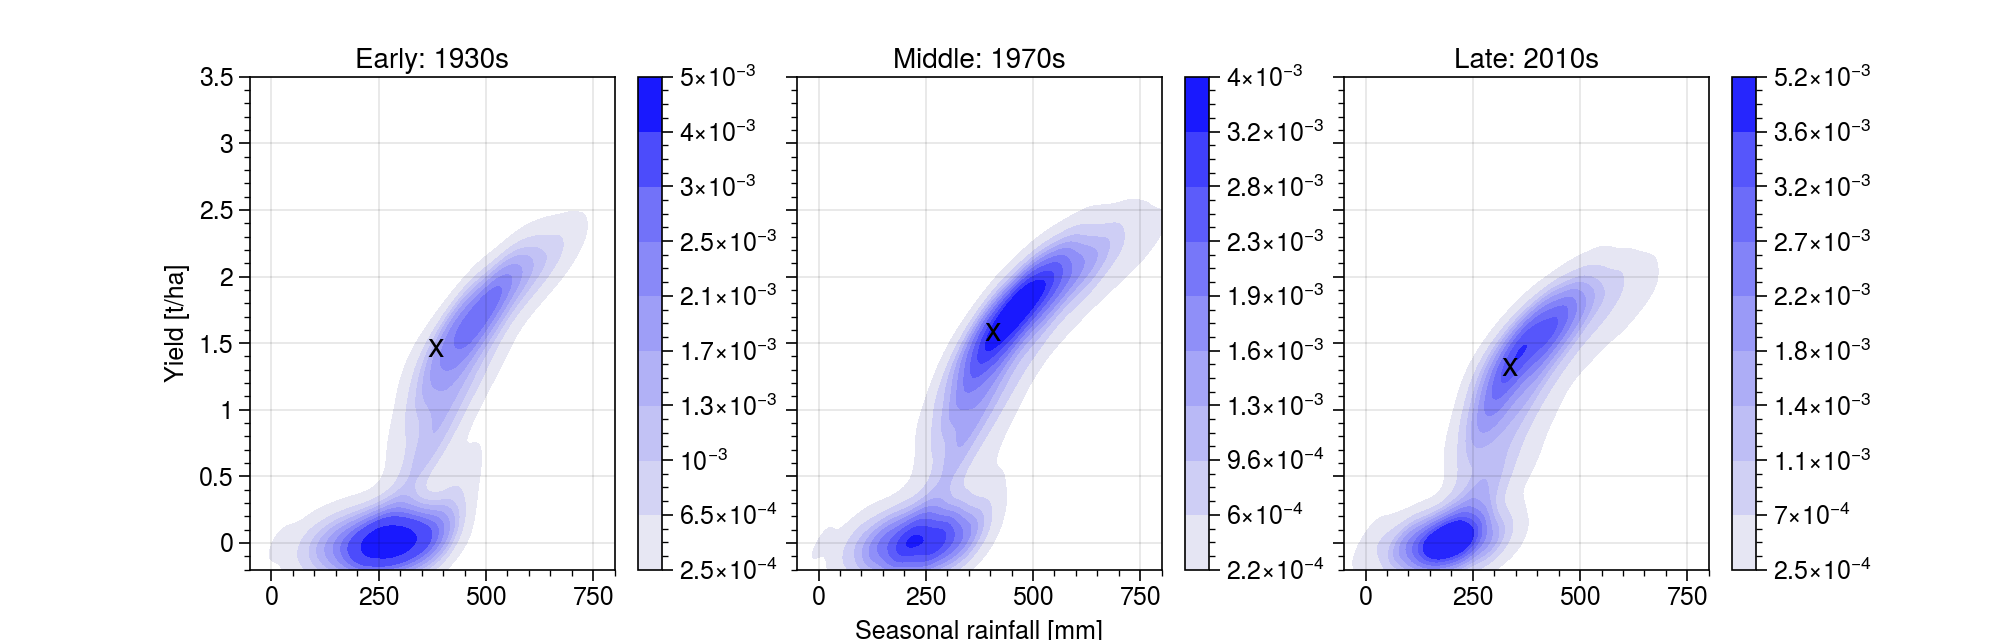

In [23]:
def fig_10():
    f, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,3.2), sharey=True, sharex=True)

    # Set colorscheme
    blues = sns.color_palette("light:b", as_cmap=True)
    col = 'black'

    # For sci notation
    import matplotlib.ticker as mticker
    f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
    g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.1e' % x))

    # Draw plots
    ax1 = ax[0]
    sns.kdeplot(data=result_early, x="RF", y="Yield", cmap=blues,cbar=True, shade = True,
                ax=ax1, cbar_kws={'format': mticker.FuncFormatter(g)}).set_title('Early: 1930s')

    ax1.text(e_rf,e_y, "x", size=12, color=col)

    ax2 = ax[1]
    sns.kdeplot(data=result_mid, x="RF", y="Yield",cmap=blues, shade=True,
                     cbar=True,ax=ax2, cbar_kws={'format': mticker.FuncFormatter(g)}).set_title('Middle: 1970s')
    ax2.text(m_rf,m_y, "x", size=12, color=col)

    ax3 = ax[2]
    sns.kdeplot(data=result_late, x="RF", y="Yield", cmap=blues, shade=True,
                 cbar=True, ax=ax3, cbar_kws={'format': mticker.FuncFormatter(g)}).set_title('Late: 2010s')

    ax3.text(l_rf,l_y, "x", size=12, color=col)
    
    # Set labels
    ax1.set(xlabel='')
    ax1.set(ylabel='Yield [t/ha]')
    ax2.set(xlabel='Seasonal rainfall [mm]')
    ax2.set(ylabel='')
    ax3.set(ylabel='')
    ax3.set(xlabel='')

    # Set axes limits
    for ax in [ax1, ax2, ax3]:
        ax.set(ylim=(-0.2,3.5))
        ax.set(xlim=(-50,800))

fig_10()